In [2]:
from nltk.stem.snowball import SnowballStemmer

import nltk
import spacy
#python -m spacy download en
from nltk.stem import WordNetLemmatizer

def tokenizer1(doc):
    spacy.load('en')
    lemmatizer = spacy.lang.en.English()
    tokens = lemmatizer(doc)
    doc=" ".join([token.lemma_ for token in tokens])
    return doc

def tokenizer2(doc):
    wordnet_lemmatizer = WordNetLemmatizer()
    doc = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in nltk.word_tokenize(doc)])
    return doc

def tokenizer3(doc):
    english_stemmer = SnowballStemmer("english")
    doc = " ".join([english_stemmer.stem(w) for w in nltk.word_tokenize(doc)])
    return doc

In [3]:
#give cleanData as pre-process
import string
import re
from string import punctuation

def cleanData(text):
    txt = str(text)
    
    # Replace apostrophes with standard lexicons
    txt = txt.replace("isn't", "is not")
    txt = txt.replace("aren't", "are not")
    txt = txt.replace("ain't", "am not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("didn't", "did not")
    txt = txt.replace("shan't", "shall not")
    txt = txt.replace("haven't", "have not")
    txt = txt.replace("hadn't", "had not")
    txt = txt.replace("hasn't", "has not")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("wasn't", "was not")
    txt = txt.replace("weren't", "were not")
    txt = txt.replace("doesn't", "does not")
    txt = re.sub(r"\'ve", " have ", txt)
    txt = re.sub(r"can't", "cannot ", txt)
    txt = re.sub(r"n't", " not ", txt)
    txt = re.sub(r"I'm", "I am", txt)
    txt = re.sub(r" m ", " am ", txt)
    txt = re.sub(r"\'re", " are ", txt)
    txt = re.sub(r"\'d", " would ", txt)
    txt = re.sub(r"\'ll", " will ", txt)
    
    # Remove urls and emails
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', txt, flags=re.MULTILINE)
    txt = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', txt, flags=re.MULTILINE)
    
    # Remove punctuation from text
    txt = ''.join([c for c in text if c not in punctuation])
#     txt = txt.replace(".", " ")
#     txt = txt.replace(":", " ")
#     txt = txt.replace("!", " ")
#     txt = txt.replace("&", " ")
#     txt = txt.replace("#", " ")
    
    # Remove all symbols
    txt = re.sub(r'[^A-Za-z0-9\s]',r' ',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    txt = re.sub(r'[0-9]',r' ',txt)
    
    return txt

# clean description
#df['Text'] = df['Text'].map(lambda x: cleanData(x))


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import stop_words
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import autosklearn.classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

class Data:
    def __init__(self, data):
      
        self.data = pd.read_csv(data)
    
    def createClasses(self):
        le = preprocessing.LabelEncoder()
        le.fit(self.data.party)
        self.data["Class"]=list(le.transform(self.data.party))
        
    def callcleanData(self):
        self.data.text = self.data.text.str.replace("[^a-zA-Z]", " ")
        self.data.text = self.data.text.map(lambda x: cleanData(x))

        # tokenization 
        tokenized_doc = self.data['text'].apply(lambda x: x.split())

        # remove stop-words 
        #tokenized_doc = tokenized_doc.apply(lambda x: [item.lower() for item in x if item not in stop_words])
        for index, word_list in enumerate(tokenized_doc):
            tokenized_doc[index] = [word.lower() for word in word_list if word.lower() not in stopwords.words('english')]

        # de-tokenization 
        detokenized_doc = [] 
        for i in range(len(self.data)): 
            t = ' '.join(tokenized_doc[i]) 
            detokenized_doc.append(t) 

        self.data['text'] = detokenized_doc
    
    
    def createEmbeddings(self, word2vec):
        embeddings = get_word2vec_embeddings(word2vec, self.data)
        list_labels=self.data['Class'].tolist()
        self.X_train_word2vec, self.X_test_word2vec, self.y_train_word2vec, self.y_test_word2vec = train_test_split(embeddings, list_labels, test_size=0.2, random_state=40)
        
    def createPartitions(self):
        self.train_feature, self.test_feature, self.train_class, self.test_class = train_test_split(self.data.text, self.data.Class, test_size=0.20,random_state=1)
        
   
    def createVectors(self, stopwords=False, useidf=False, ngram=(1,1), tokenizer=None):
        if (stopwords==True):
            self.vectorizer = TfidfVectorizer(use_idf=useidf, stop_words='english', ngram_range=ngram, min_df=3, max_df=0.9, tokenizer=tokenizer)
        else:   
            self.vectorizer = TfidfVectorizer(use_idf=useidf, min_df=3, max_df=0.9, ngram_range=ngram, tokenizer=tokenizer)

        self.trainvec = self.vectorizer.fit_transform(self.train_feature)
        self.testvec = self.vectorizer.transform(self.test_feature)
        
        return self.vectorizer
    
    def createClassifier(self, mode):
        # SINGLE CLASSIFIERS
        
        #classifiers=["MultinomialNB", "KNeighborsClassifier", "Perceptron", "LinearSVC"]
        #classifiers=["MLPClassifier", "DecisionTree", "RandomForest"]
        classifiers=["LinearSVC"]
        opt_classifiers=[]
        scores_array=[]
        
        #Once chosen we get all the measures
        if (mode=="chosen"):
            svc=LinearSVC()
            #svc=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True,tol=0.001, verbose=False)
            svc.fit(self.trainvec, self.train_class)
            self.clf=svc
            predictions=svc.predict(self.testvec)
           
            accuracy, precision, recall, f1 = self.get_metrics(self.test_class, predictions)
            measures=[accuracy, precision, recall, f1]
            all_metrics=metrics.classification_report(self.test_class, predictions, target_names=self.data.party.unique())

            return [self.clf, measures, all_metrics]       
        
        #For each classifier (cls) we build an optimal version: opt_cls
        if (mode=="normal"):
            for cls in classifiers:
                opt_cls=self.optimizeClassifier(cls) 
                opt_classifiers.append(opt_cls)
                scores_array.append(opt_cls[2])

            #We fetch the best classifier amongst the optimal versions built previously
            max_acc=max(scores_array)
            index=scores_array.index(max_acc)
            best_cls=opt_classifiers[index]            
            return best_cls
        
        #Word2Vec Embeddings
        if (mode=="w2v"):
            clf_w2v = LinearSVC()
            clf_w2v.fit(self.X_train_word2vec, self.y_train_word2vec)
            y_predicted_word2vec = clf_w2v.predict(self.X_test_word2vec)
            
            accuracy, precision, recall, f1 = self.get_metrics(self.y_test_word2vec, y_predicted_word2vec)
            measures=[accuracy, precision, recall, f1]
            all_metrics=metrics.classification_report(self.y_test_word2vec, y_predicted_word2vec, target_names=self.data.party.unique())
            
            return [measures, all_metrics]
        
        #AUTOMATIC CLASSIFIER - EMSEMBLE
        if (mode=="auto"):
            classifier = autosklearn.classification.AutoSklearnClassifier()
            classifier.fit(self.trainvec, self.train_class)
            predictions = classifier.predict(self.testvec)
            accuracy_auto=accuracy_score(self.test_class, predictions)
            return accuracy_auto
    
    def optimizeClassifier(self, classifier):
        if (classifier=="MLPClassifier"):
            act_parameters = ['relu', 'logistic']
            nn_scores=[]
            for act in act_parameters:
                nn=MLPClassifier(activation=act)
                nn.fit(self.trainvec, self.train_class)
                predictions=nn.predict(self.testvec)
                acc = accuracy_score(self.test_class, predictions)
                nn_scores.append(acc)
                
            max_acc=max(nn_scores)
            index=nn_scores.index(max_acc)
            best=act_parameters[index]
        
        if (classifier=="DecisionTree"):
            samplesdt_parameters = [1, 5]
            dt_scores=[]
            for sample in samplesdt_parameters:
                dt=DecisionTreeRegressor(min_samples_leaf=sample)
                dt.fit(self.trainvec, self.train_class)
                predictions=dt.predict(self.testvec)
                acc = accuracy_score(self.test_class, predictions.round())
                dt_scores.append(acc)
                
            max_acc=max(dt_scores)
            index=dt_scores.index(max_acc)
            best=samplesdt_parameters[index]
            
        if (classifier=="RandomForest"):
            samplesrf_parameters = [1, 5]
            rf_scores=[]
            for sample in samplesrf_parameters:
                rf=RandomForestClassifier(min_samples_leaf=sample)
                rf.fit(self.trainvec, self.train_class)
                predictions=rf.predict(self.testvec)
                acc = accuracy_score(self.test_class, predictions.round())
                rf_scores.append(acc)
                
            max_acc=max(rf_scores)
            index=rf_scores.index(max_acc)
            best=samplesrf_parameters[index]
                    
        if (classifier=="MultinomialNB"):
            alpha_parameters = [0.1,0.5,1.0]
            mnb_scores=[]
            for alpha in alpha_parameters:
                mnb=MultinomialNB(alpha=alpha)
                mnb.fit(self.trainvec, self.train_class)
                predictions=mnb.predict(self.testvec)
                acc = accuracy_score(self.test_class, predictions)
                mnb_scores.append(acc)
                
            max_acc=max(mnb_scores)
            index=mnb_scores.index(max_acc)
            best=alpha_parameters[index]

        if (classifier=="KNeighborsClassifier"):          
            k_parameters = [3,5,7,9,11]
            knn_scores=[]
            for k in k_parameters:
                knn=KNeighborsClassifier(n_neighbors=k)
                knn.fit(self.trainvec, self.train_class)
                predictions=knn.predict(self.testvec)
                acc = accuracy_score(self.test_class, predictions)
                knn_scores.append(acc)
                
            max_acc=max(knn_scores)
            index=knn_scores.index(max_acc)
            best=k_parameters[index]
        
        if (classifier=="Perceptron"):          
            p_parameters = ['None', 'l2' , 'l1' , 'elasticnet']
            perc_scores=[]
            for p in p_parameters:
                perc=Perceptron(max_iter=1000, tol=1e-3, penalty=p)
                perc.fit(self.trainvec, self.train_class)
                predictions=perc.predict(self.testvec)
                acc = accuracy_score(self.test_class, predictions)
                perc_scores.append(acc)
                
            max_acc=max(perc_scores)
            index=perc_scores.index(max_acc)
            best=p_parameters[index]
            
        if (classifier=="LinearSVC"):
            #s_parameters = ['linear', 'rbf']
            s_parameters=['linear']
            svc_scores=[]
            for s in s_parameters:
                svc=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel=s, max_iter=-1, probability=False, random_state=None, shrinking=True,tol=0.001, verbose=False)
                svc.fit(self.trainvec, self.train_class)
                predictions=svc.predict(self.testvec)
                acc = accuracy_score(self.test_class, predictions)
                svc_scores.append(acc)
                
            max_acc=max(svc_scores)
            index=svc_scores.index(max_acc)
            best=s_parameters[index]
       
        opt_cls=[classifier, best, max_acc]
        return  opt_cls

    def get_metrics(self, y_test, y_predicted):  
        # true positives / (true positives+false positives)
        precision = precision_score(y_test, y_predicted, pos_label=None,
                                        average='weighted')             
        # true positives / (true positives + false negatives)
        recall = recall_score(y_test, y_predicted, pos_label=None,
                                  average='weighted')

        # harmonic mean of precision and recall
        f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

        # true positives + true negatives/ total
        accuracy = accuracy_score(y_test, y_predicted)
        return accuracy, precision, recall, f1

AxesSubplot(0.125,0.125;0.775x0.755)

COMPLETE INFO:
count                 16726
unique                   11
top       Liberal Democrats
freq                   3013
Name: party, dtype: object

INFO OF LIBERALS:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3013 entries, 17 to 10709
Data columns (total 5 columns):
text            3013 non-null object
manifesto_id    3013 non-null object
party           3013 non-null object
date            3013 non-null int64
title           3013 non-null object
dtypes: int64(1), object(4)
memory usage: 141.2+ KB

PERCENTAGE OF LIBERALS: 0.18013870620590697


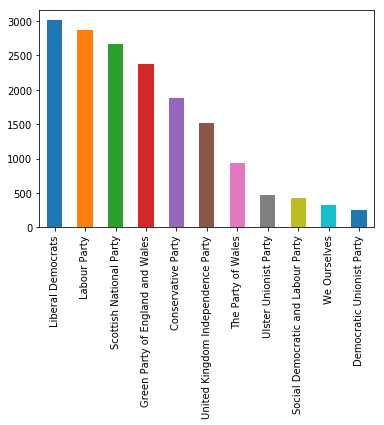

In [76]:
#Classes Distributions - BASELINE
file=open("en_docs_clean.csv", "r")
data = Data(file)
dist=data.data.party.value_counts().plot.bar()
print(dist)

print()
print("COMPLETE INFO:")
print(data.data.party.describe())
print()
Liberal=data.data[data3.data.party=="Liberal Democrats"]
print("INFO OF LIBERALS:")
Liberal.info()

print()
print("PERCENTAGE OF LIBERALS:", 3013/16726)

In [30]:

data_combinations=[]

for value1 in [True, False]:
    for value2 in [True, False]:
        file=open("en_docs_clean.csv", "r")
        data = Data(file)
        data.createClasses()
        data.createPartitions()
        data.createVectors(stopwords=value1, useidf=value2, ngram=(1,1))
        data_combinations.append(data)


In [20]:
classifiers_normal_combinations=[]
for data in data_combinations:  
    normal_classifier=data.createClassifier("normal")
    classifiers_normal_combinations.append(normal_classifier)


In [21]:
print(classifiers_normal_combinations)

[['LinearSVC', 'linear', 0.4811715481171548], ['LinearSVC', 'linear', 0.4781829049611476], ['LinearSVC', 'linear', 0.5059772863120143], ['LinearSVC', 'linear', 0.49222952779438134]]


First Round of Classifiers Result: Using IDF but no stopwords, and a LinearSVC classifier we obtained 50,6% accuracy.

In [27]:
classifiers_normal_combinations=[]
for data in data_combinations:  
    normal_classifier=data.createClassifier("normal")
    classifiers_normal_combinations.append(normal_classifier)


/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

In [28]:
print(classifiers_normal_combinations)

[['RandomForest', 1, 0.41721458457860133], ['MLPClassifier', 'logistic', 0.42887029288702927], ['MLPClassifier', 'logistic', 0.4378362223550508], ['MLPClassifier', 'logistic', 0.4533771667662881]]


Second round results: No classifier performed better than before. 

In [112]:
#From previous results value1=False  and value2=True
value1=False
value2=True
data_gram_combinations=[]
for gram in range(2,5):  #testing (1,2), (1,3) (1,4)
    file=open("en_docs_clean.csv", "r")
    data = Data(file)
    data.createClasses()
    data.createPartitions()
    data.createVectors(stopwords=value1, useidf=value2, ngram=(1,gram))
    data_gram_combinations.append(data)
    

In [113]:
classifiers_normal_gram_combinations=[]
for data in data_gram_combinations:  
    classifier_normal=data.createClassifier("normal")
    classifiers_normal_gram_combinations.append(classifier_normal)

In [114]:
print(classifiers_normal_gram_combinations)

[['LinearSVC', 'linear', 0.5352659892408846], ['LinearSVC', 'linear', 0.5448296473401076], ['LinearSVC', 'linear', 0.5469216975493126]]


Third round results: Using IDF but no stop words, with 4-gram words the accuracy of LinearSVC was 54,7%

In [64]:
#From previous results value1=False  and value2=True and ngram_range=(1,4) and preprocessing True or False ??
value1=False
value2=True
ngram=(1,4)

file=open("en_docs_clean.csv", "r")
data = Data(file)
data.callcleanData()
data.createClasses()
data.createPartitions()
data.createVectors(stopwords=value1, useidf=value2, ngram=ngram)
classifier_normal=data.createClassifier("normal")
print(classifier_normal)

['LinearSVC', 'linear', 0.543335325762104]


Forth round: no improvement with data cleaning

In [66]:
#From previous results value1=False  and value2=True and ngram_range=(1,4) 
value1=False
value2=True
ngram=(1,4)
data_tok_combinations=[]
for tok in [tokenizer1, tokenizer2]:
    file=open("en_docs_clean.csv", "r")
    data = Data(file)
    data.createClasses()
    data.createPartitions()
    data.createVectors(stopwords=value1, useidf=value2, ngram=ngram, tokenizer=tok)
    data_tok_combinations.append(data)
    

In [67]:
classifiers_normal_tok_combinations=[]
for data in data_tok_combinations:  
    classifier_normal=data.createClassifier("normal")
    classifiers_normal_tok_combinations.append(classifier_normal)

In [68]:
print(classifiers_normal_tok_combinations)

[['LinearSVC', 'linear', 0.5271966527196653], ['LinearSVC', 'linear', 0.5280932456664674]]


Fifth round: no improvement with any lemmatizer

In [72]:
#From previous results value1=False  and value2=True and ngram_range=(1,4) 
value1=False
value2=True
ngram=(1,4)
file=open("en_docs_clean.csv", "r")
data = Data(file)
data.createClasses()
data.createPartitions()
data.createVectors(stopwords=value1, useidf=value2, ngram=ngram, tokenizer=tokenizer3)
classifier_normal=data.createClassifier("normal")
print(classifier_normal)    

['LinearSVC', 'linear', 0.5292887029288703]


Sixth round: no improvement with stemmer.

In [115]:
#From previous results value1=False  and value2=True and ngram_range=(1,4) 
value1=False
value2=True
data_more_combinations=[]
for ngram in [(1,4), (1,5), (1,6), (1,7)]:
    file=open("en_docs_clean.csv", "r")
    data = Data(file)
    data.createClasses()
    data.createPartitions()
    data.createVectors(stopwords=value1, useidf=value2, ngram=ngram)
    data_more_combinations.append(data)


In [116]:
classifiers_normal_more_combinations=[]
for data in data_more_combinations:  
    classifier_normal=data.createClassifier("normal")
    classifiers_normal_more_combinations.append(classifier_normal)


In [117]:
print(classifiers_normal_more_combinations)

[['LinearSVC', 'linear', 0.5469216975493126], ['LinearSVC', 'linear', 0.5460251046025104], ['LinearSVC', 'linear', 0.5460251046025104], ['LinearSVC', 'linear', 0.5457262402869097]]


Seventh round: the gram (1,4) was the optimal.

In [128]:
#Using SVC
value1=False
value2=True
ngram=(1,4)
file=open("en_docs_clean.csv", "r")
data = Data(file)
data.createClasses()
data.createPartitions()
vectorizer=data.createVectors(stopwords=value1, useidf=value2, ngram=ngram)
clf, measures=data.createClassifier("chosen")

accuracy=measures[0]
precision=measures[1]
recall=measures[2]
f1=measures[3]

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.547, precision = 0.580, recall = 0.547, f1 = 0.542


In [129]:
#using SVC and cleaning data
value1=False
value2=True
ngram=(1,4)
file=open("en_docs_clean.csv", "r")
data = Data(file)
data.callcleanData()
data.createClasses()
data.createPartitions()
vectorizer_clean = data.createVectors(stopwords=value1, useidf=value2, ngram=ngram)
clf_clean, measures_clean=data.createClassifier("chosen")

accuracy=measures_clean[0]
precision=measures_clean[1]
recall=measures_clean[2]
f1=measures_clean[3]

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.507, precision = 0.545, recall = 0.507, f1 = 0.504


Cleaning improves none of the metrics

In [169]:
#Using LinearSVC
value1=False
value2=True
ngram=(1,4)
file=open("en_docs_clean.csv", "r")
data = Data(file)
data.createClasses()
data.createPartitions()
vectorizer=data.createVectors(stopwords=value1, useidf=value2, ngram=ngram)
clf, measures=data.createClassifier("chosen")

accuracy=measures[0]
precision=measures[1]
recall=measures[2]
f1=measures[3]

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.558, precision = 0.567, recall = 0.558, f1 = 0.555


Using Linear SVC improved the classifier by 55,8% accuracy.

In [184]:
#Using LinearSVC and metrics 
value1=False
value2=True
ngram=(1,4)
file=open("en_docs_clean.csv", "r")
data = Data(file)
data.createClasses()
data.createPartitions()
vectorizer=data.createVectors(stopwords=value1, useidf=value2, ngram=ngram)
clf, measures, met=data.createClassifier("chosen")




In [188]:
accuracy=measures[0]
precision=measures[1]
recall=measures[2]
f1=measures[3]

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

print()
print(met)

accuracy = 0.558, precision = 0.567, recall = 0.558, f1 = 0.555

                                    precision    recall  f1-score   support

                      Labour Party       0.54      0.52      0.53       389
                Conservative Party       0.65      0.39      0.48        57
                 Liberal Democrats       0.56      0.65      0.60       451
           Scottish National Party       0.54      0.59      0.56       572
 United Kingdom Independence Party       0.47      0.57      0.52       613
  Green Party of England and Wales       0.65      0.66      0.66       526
                      We Ourselves       0.82      0.35      0.49        81
Social Democratic and Labour Party       0.79      0.55      0.65       185
             Ulster Unionist Party       0.30      0.13      0.18        99
                The Party of Wales       0.54      0.46      0.50       310
         Democratic Unionist Party       0.81      0.48      0.60        63

                     

In [190]:
#Using LinearSVC and cleaning data
value1=False
value2=True
ngram=(1,4)
file=open("en_docs_clean.csv", "r")
data = Data(file)
data.callcleanData()
data.createClasses()
data.createPartitions()
vectorizer_clean = data.createVectors(stopwords=value1, useidf=value2, ngram=ngram)
clf_clean, measures_clean, met_clean=data.createClassifier("chosen")



In [191]:
accuracy=measures_clean[0]
precision=measures_clean[1]
recall=measures_clean[2]
f1=measures_clean[3]

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

print()
print(met_clean)

accuracy = 0.515, precision = 0.520, recall = 0.515, f1 = 0.512

                                    precision    recall  f1-score   support

                      Labour Party       0.43      0.40      0.41       389
                Conservative Party       0.62      0.42      0.50        57
                 Liberal Democrats       0.52      0.59      0.55       451
           Scottish National Party       0.49      0.54      0.51       572
 United Kingdom Independence Party       0.44      0.53      0.48       613
  Green Party of England and Wales       0.63      0.63      0.63       526
                      We Ourselves       0.68      0.37      0.48        81
Social Democratic and Labour Party       0.73      0.55      0.63       185
             Ulster Unionist Party       0.34      0.12      0.18        99
                The Party of Wales       0.49      0.44      0.46       310
         Democratic Unionist Party       0.70      0.51      0.59        63

                     

Eighth round: Linear SVM improved results but not with cleaned data

In [192]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vectorizer, clf, 10)

importance_clean = get_most_important_features(vectorizer_clean, clf_clean, 10)

In [193]:
#coef_ : array, shape = [n_class * (n_class-1) / 2, n_features]
print(clf.coef_.shape[0])
print(clf.coef_.shape[1])
print(len(importance))
print(len(importance_clean))

data.data.Class.unique()


11
58540
11
11
Labour Party


In [198]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Inversely Related', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Strongly Related', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()



Labour Party


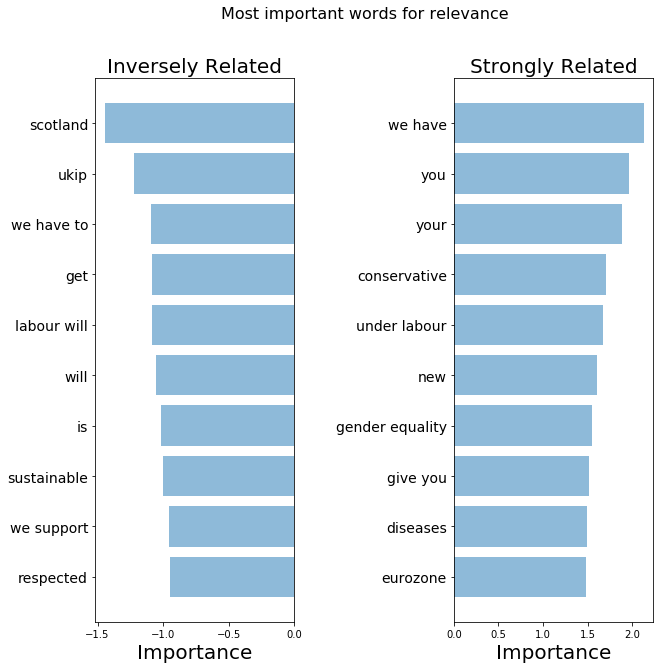

Conservative Party


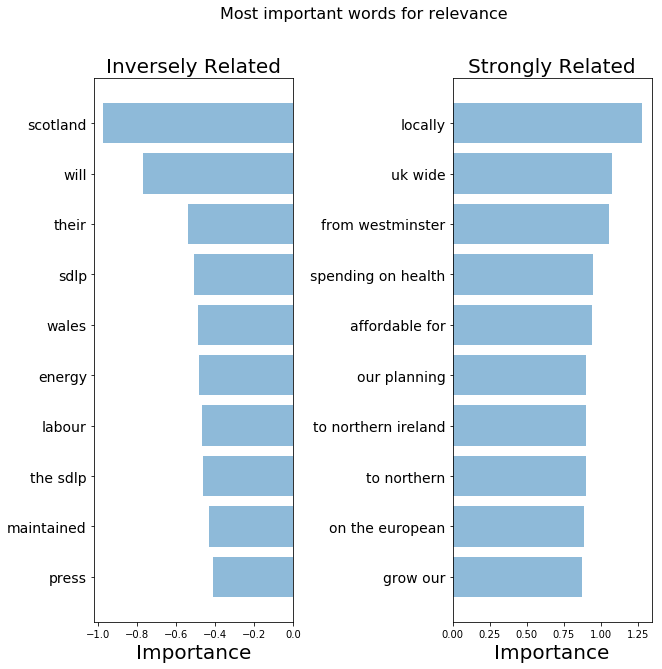

Liberal Democrats


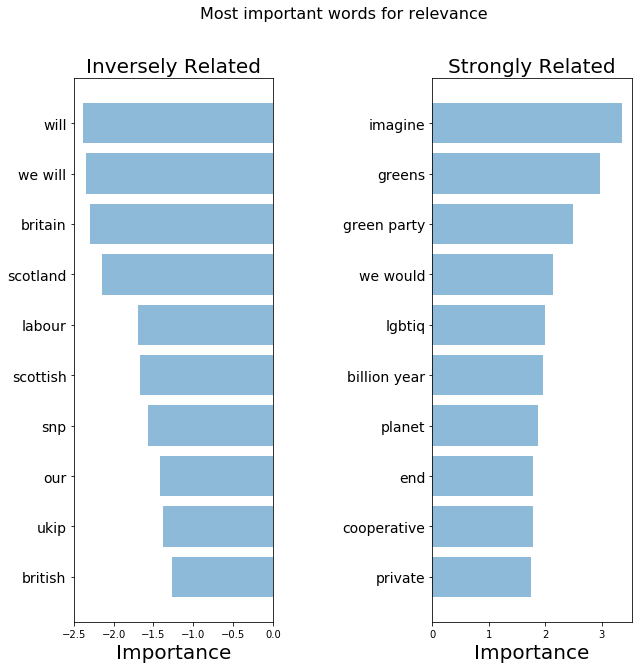

Scottish National Party


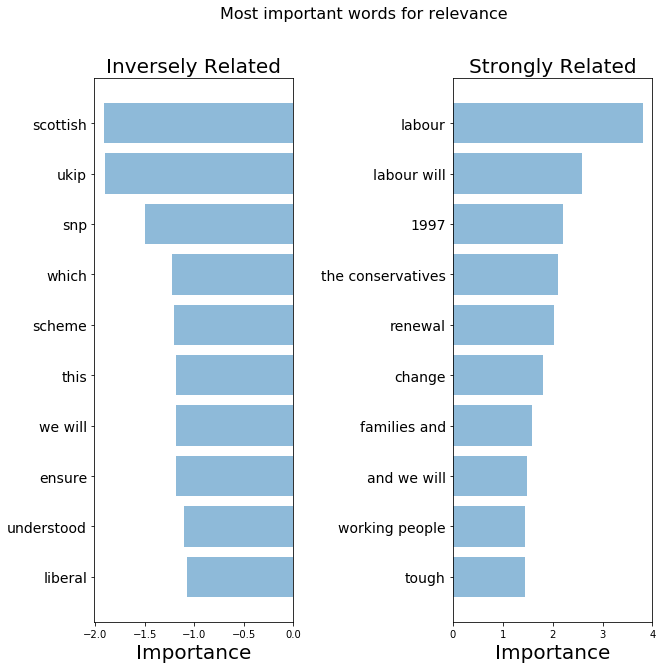

United Kingdom Independence Party


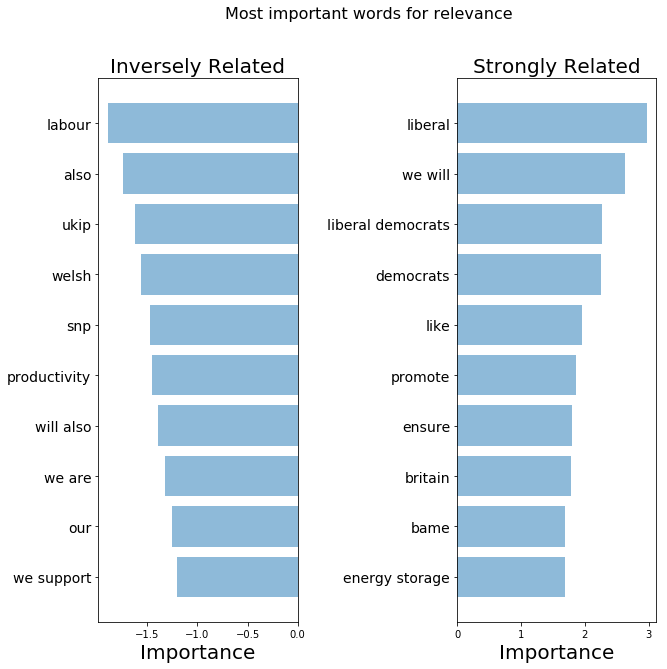

Green Party of England and Wales


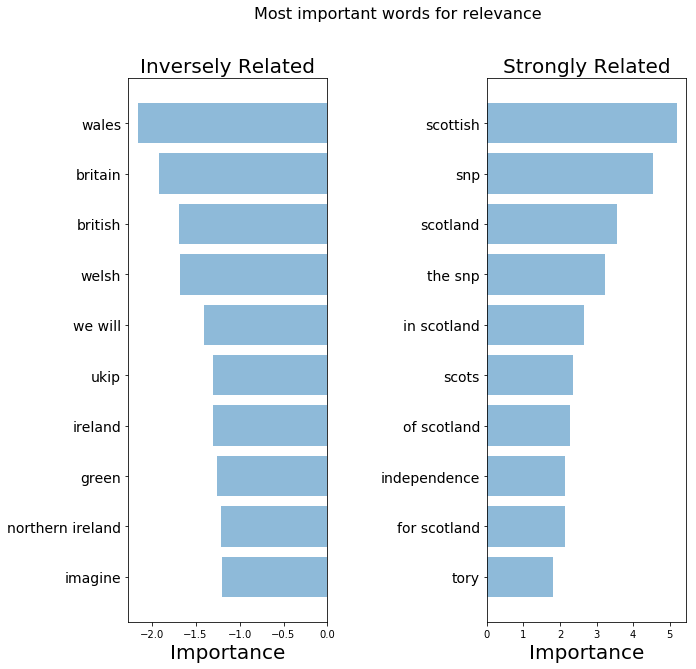

We Ourselves


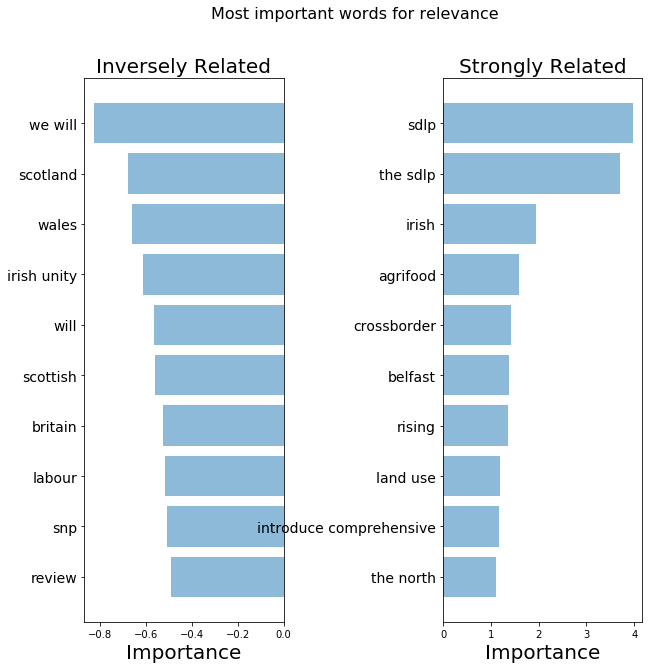

Social Democratic and Labour Party


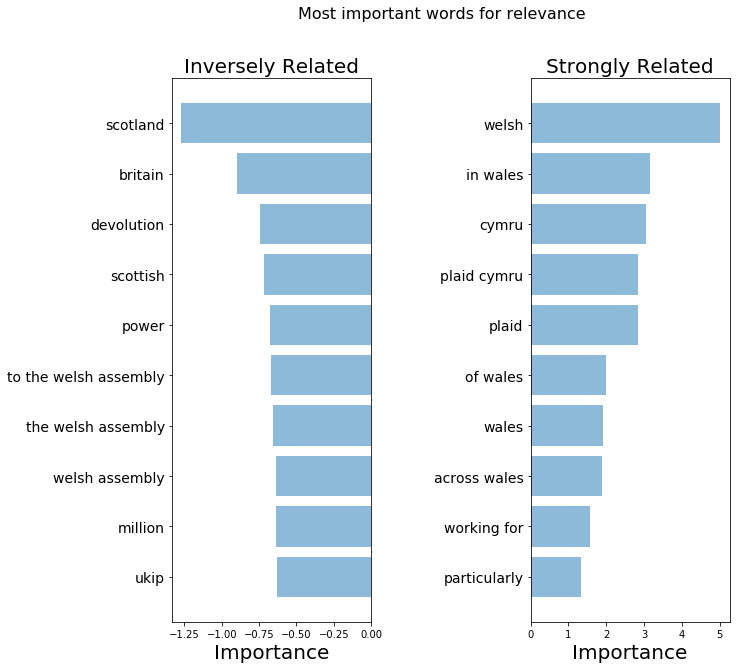

Ulster Unionist Party


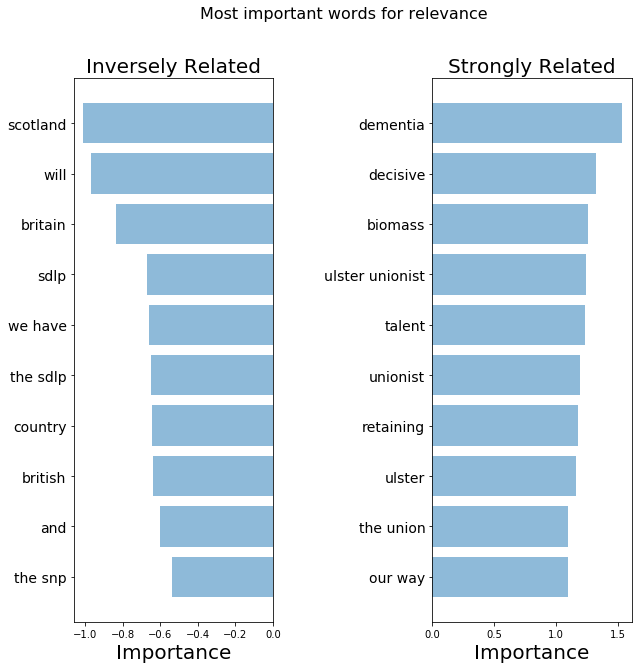

The Party of Wales


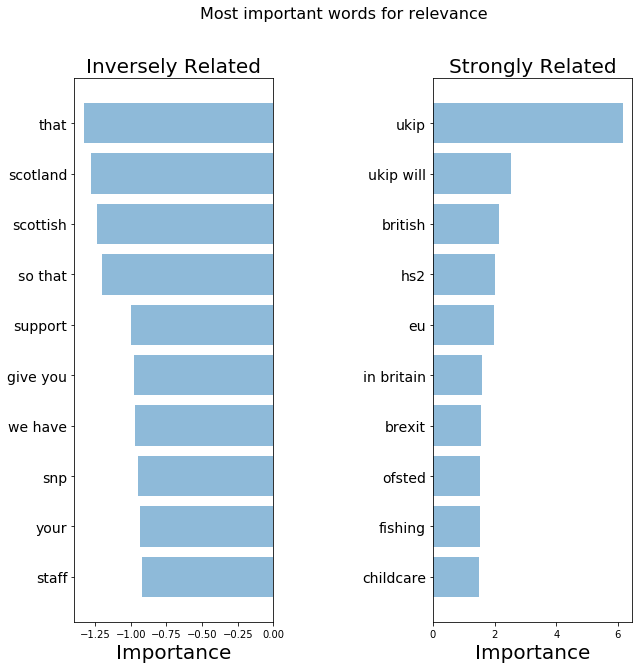

Democratic Unionist Party


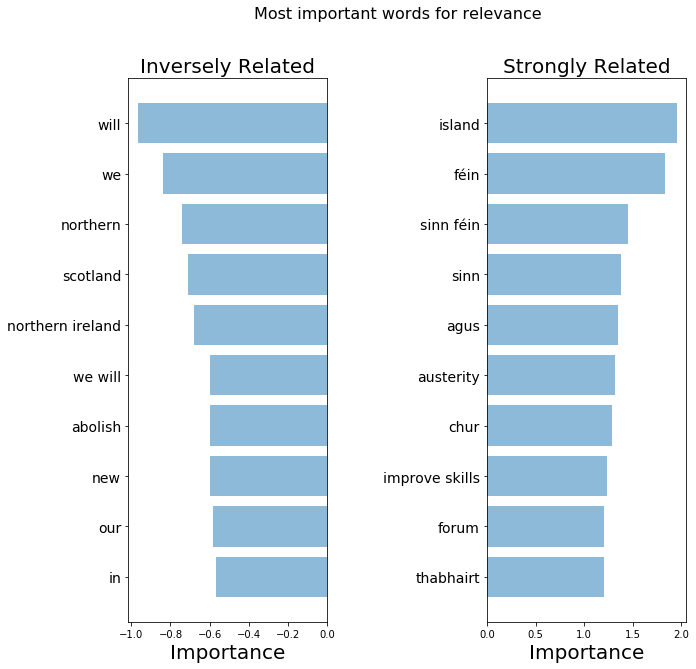

In [199]:
#Important words for SVM 
for i in range(len(list(data.data.Class.unique()))):
    print(list(data.data.party.unique())[i])
    
    top_scores = [a[0] for a in importance[i]['tops']]
    top_words = [a[1] for a in importance[i]['tops']]
    bottom_scores = [a[0] for a in importance[i]['bottom']]
    bottom_words = [a[1] for a in importance[i]['bottom']]

    plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Labour Party


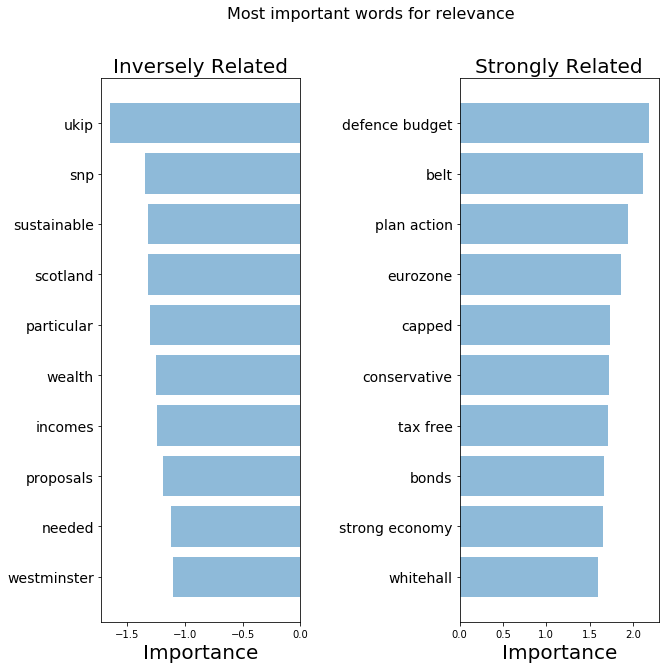

Conservative Party


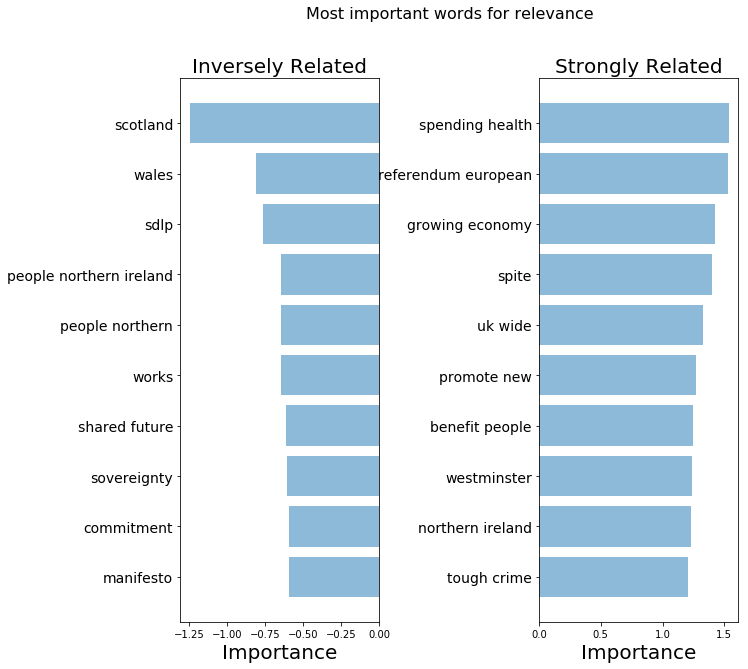

Liberal Democrats


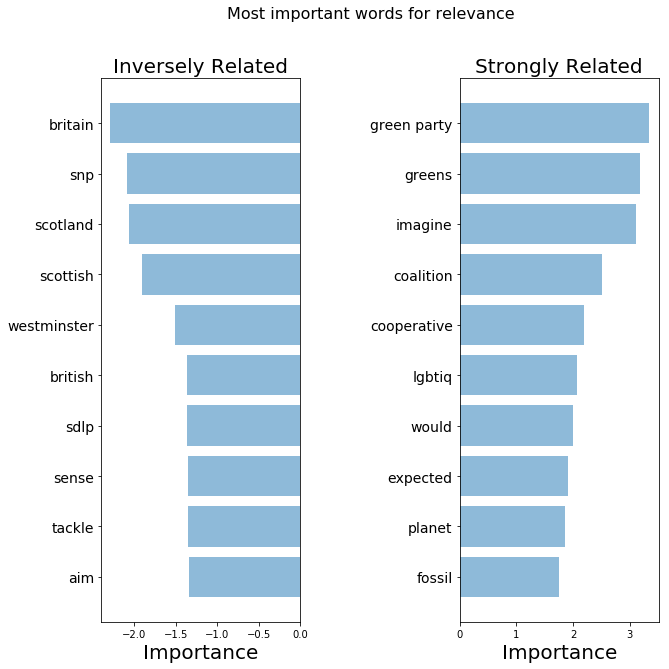

Scottish National Party


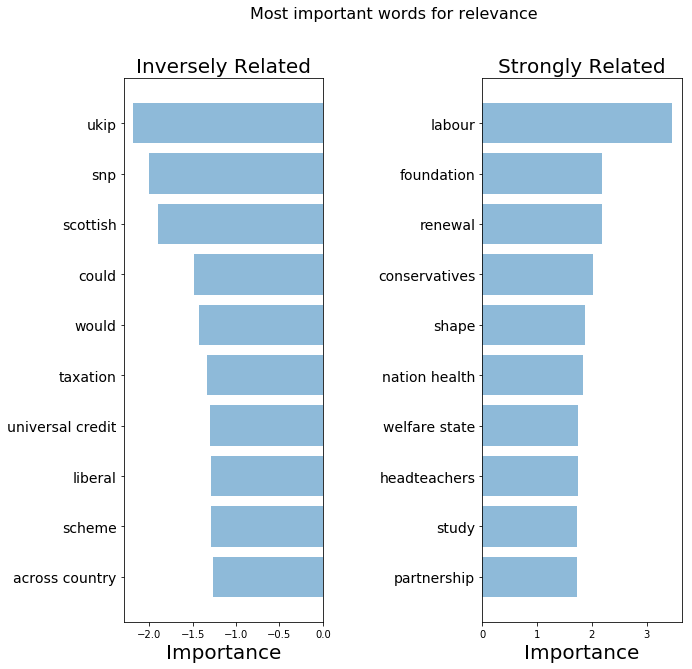

United Kingdom Independence Party


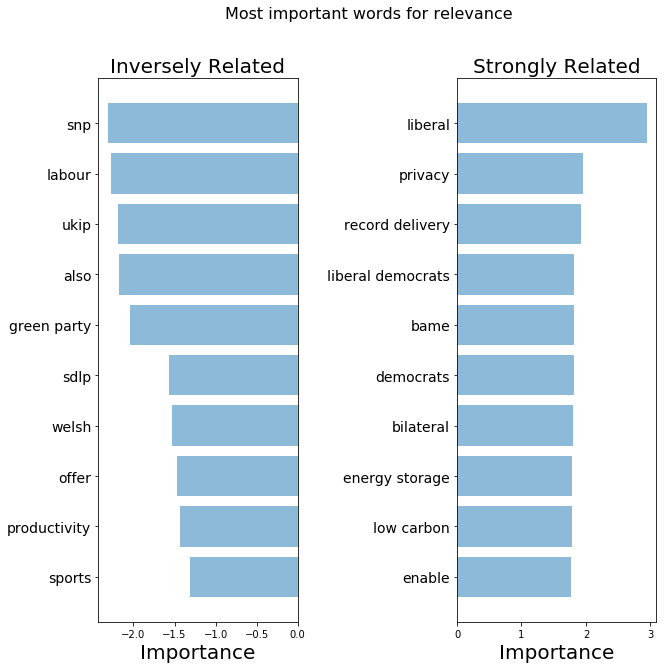

Green Party of England and Wales


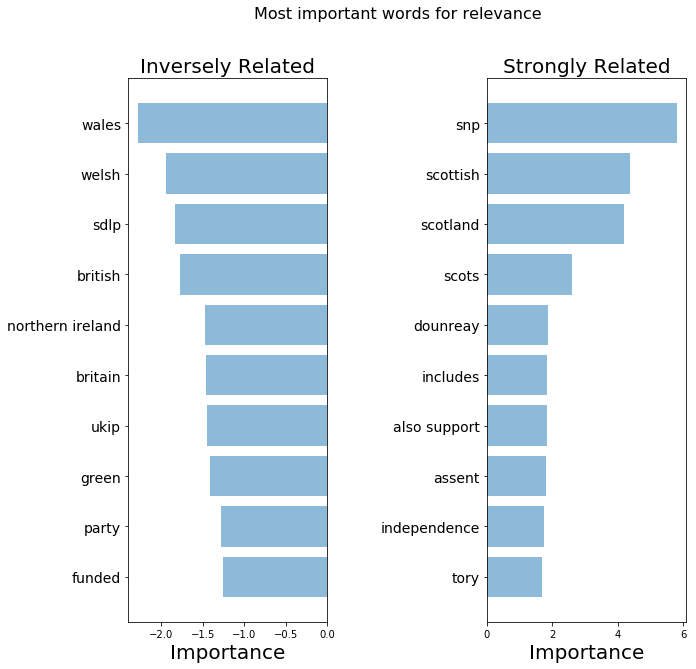

We Ourselves


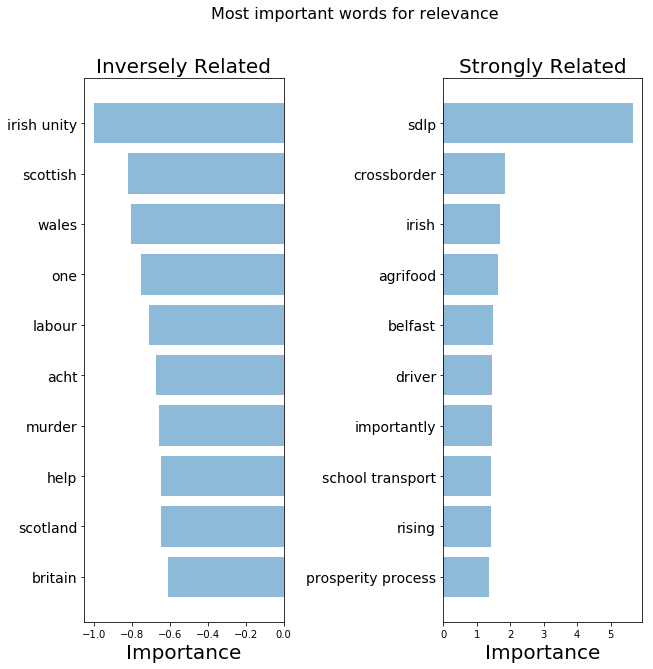

Social Democratic and Labour Party


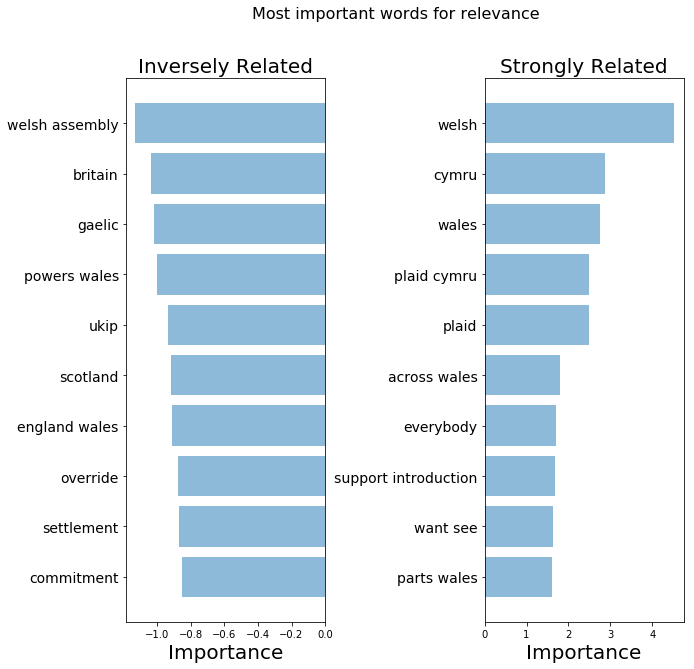

Ulster Unionist Party


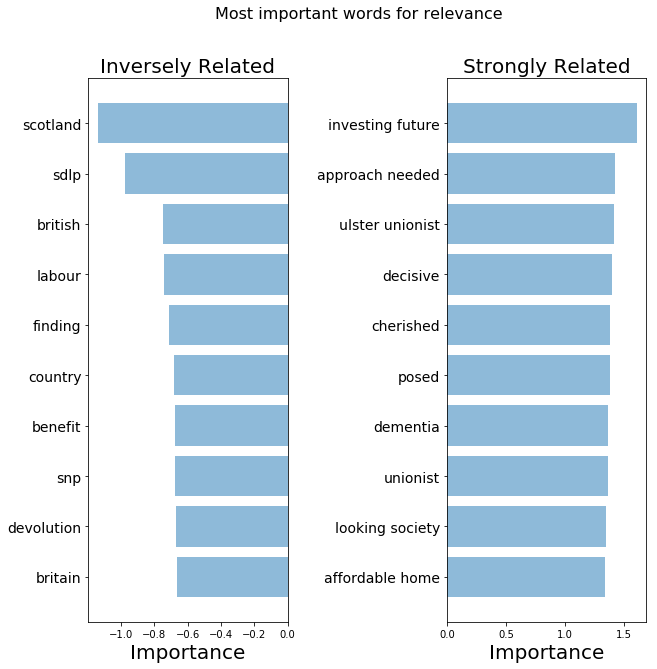

The Party of Wales


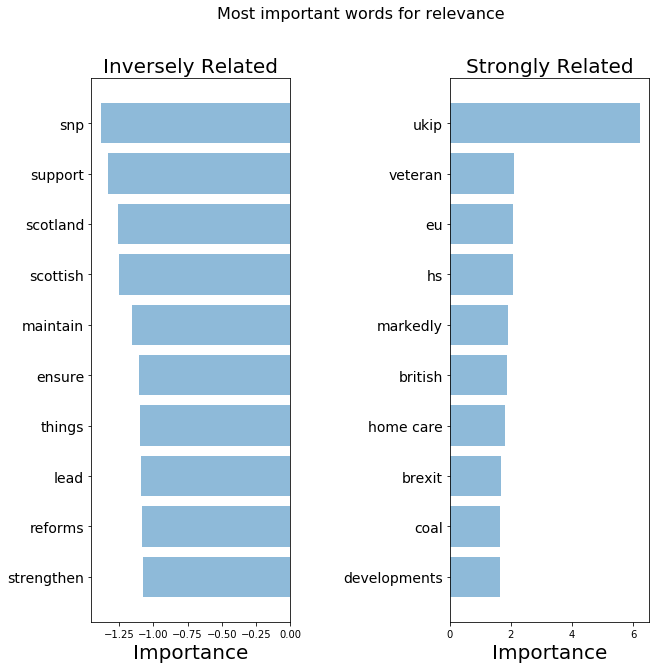

Democratic Unionist Party


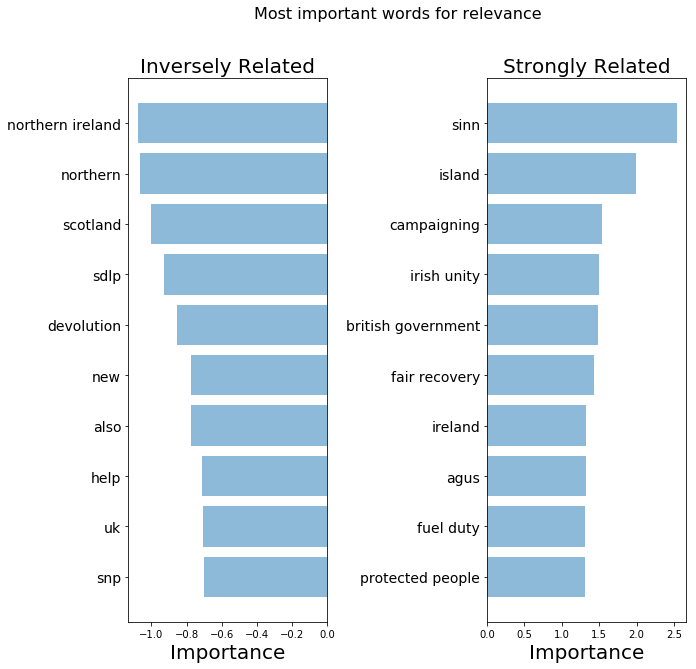

In [200]:
#Important words for SVM with data cleaning
for i in range(len(list(data.data.Class.unique()))):
    print(list(data.data.party.unique())[i])
    
    top_scores = [a[0] for a in importance_clean[i]['tops']]
    top_words = [a[1] for a in importance_clean[i]['tops']]
    bottom_scores = [a[0] for a in importance_clean[i]['bottom']]
    bottom_words = [a[1] for a in importance_clean[i]['bottom']]

    plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [62]:
file=open("en_docs_clean.csv", "r")
data=pd.read_csv(file)

data.text = data.text.str.replace("[^a-zA-Z]", " ")
data.text = data.text.map(lambda x: cleanData(x))

# tokenization 
tokenized_doc = data['text'].apply(lambda x: x.split())

# remove stop-words 
#tokenized_doc = tokenized_doc.apply(lambda x: [item.lower() for item in x if item not in stop_words])
for index, word_list in enumerate(tokenized_doc):
    tokenized_doc[index] = [word.lower() for word in word_list if word.lower() not in stopwords.words('english')]

# de-tokenization 
detokenized_doc = [] 
for i in range(len(data)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

data['text'] = detokenized_doc

le = preprocessing.LabelEncoder()
le.fit(data.party)
data["Class"]=list(le.transform(data.party))



'\nall_words = [word for tokens in clean_questions["tokens"] for word in tokens]\nsentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]\nVOCAB = sorted(list(set(all_words)))\nprint("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))\nprint("Max sentence length is %s" % max(sentence_lengths))\n'

In [79]:
data=data[['text', 'Class']]

In [82]:

all_words = [word for tokens in data["text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["text"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))


2805085 words total, with a vocabulary size of 27
Max sentence length is 127093


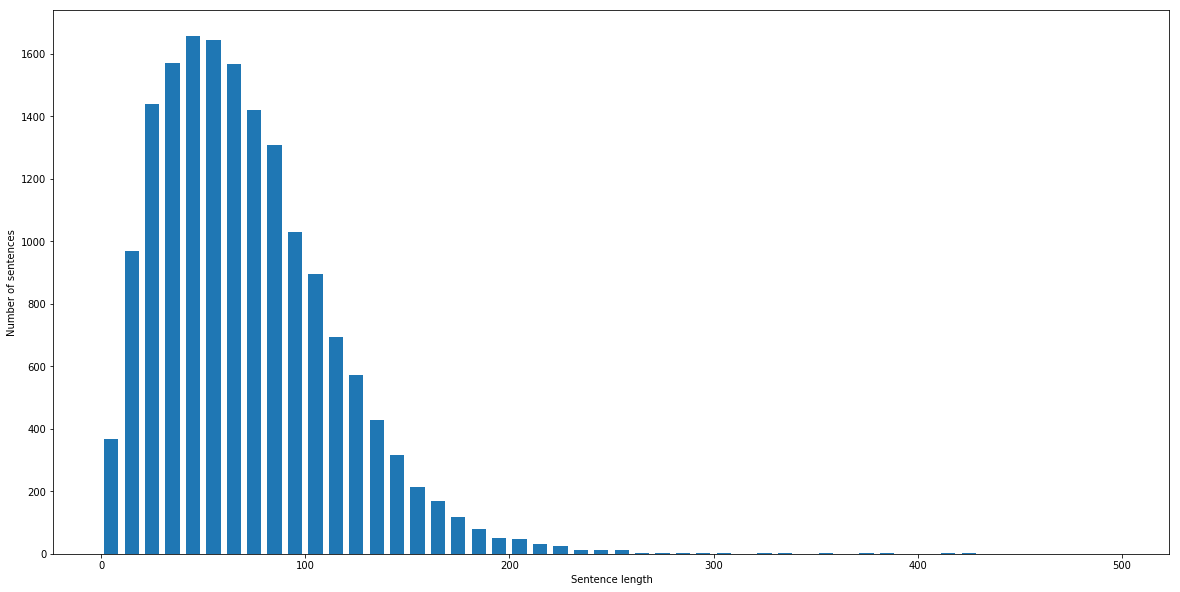

In [98]:
fig = plt.figure(figsize=(20, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths,rwidth=0.7, bins=50, range=(0, 500))
plt.show()

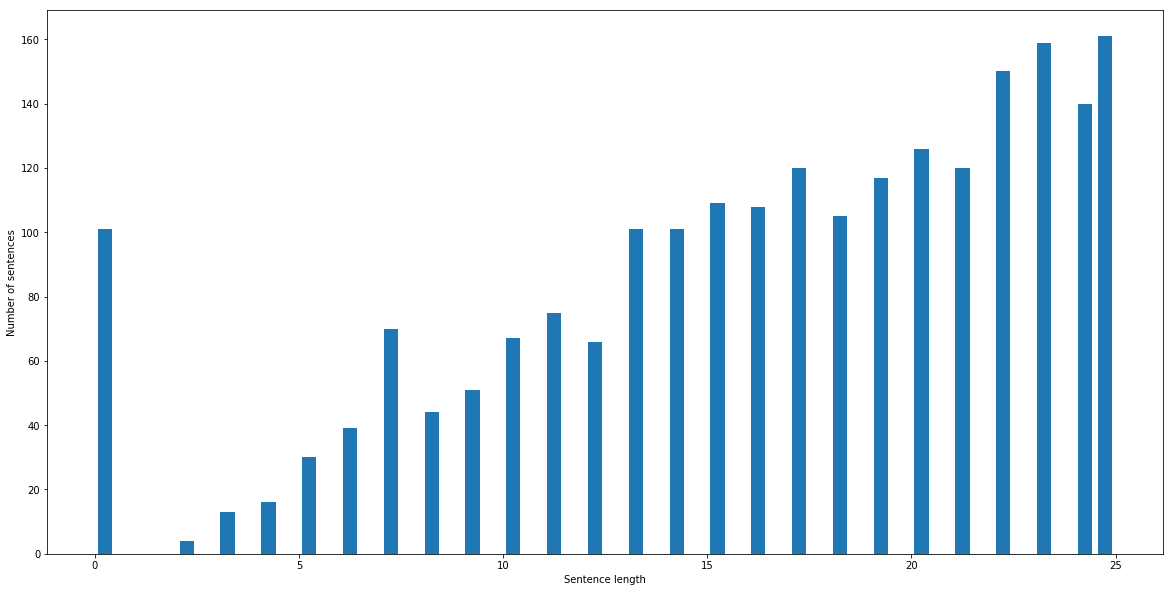

In [101]:
fig = plt.figure(figsize=(20, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths,rwidth=0.7, bins=50, range=(0, 25))
plt.show()

In [9]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def get_average_word2vec(tokens_list, vector, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data['text'].apply(lambda x: get_average_word2vec(x, vectors))
    return list(embeddings)

In [24]:
file=open("en_docs_clean.csv", "r")
data = Data(file)
data.createClasses()
data.createEmbeddings(word2vec)
measures_w2v, met_w2v=data.createClassifier("w2v")

/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andreia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
accuracy=measures_w2v[0]
precision=measures_w2v[1]
recall=measures_w2v[2]
f1=measures_w2v[3]

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.281, precision = 0.311, recall = 0.281, f1 = 0.247


In [ ]:
#Missing:
#metadata
#ver termows associados a cada partido e ver a sua frwequncia nos outros partidos

In [1]:
#use_idf: If use_idf is set to True (which is the default), then inverse document frequency is taken into account during 
#transformation. What this causes is that tokens that appear in a lot of documents will be automatically deemed less 
#informative than those that appear in fewer documents.
#If you set it to False, only term-frequency (count of words in a document) is used.


THINGS THAT DIDN'T WORK:

In [55]:
#Tried FASTAI

#Source: #https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A%20AnalyticsVidhya%20(Analytics%20Vidhya)&fbclid=IwAR1WB-6GBpZP06PtKJwY-riyKKwpO7bYvP5TpGTMQqrG1_8uPTX6E9EAaks
#pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
#pip install fastai
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

file=open("en_docs_clean.csv", "r")
data=pd.read_csv(file)

data.text = data.text.str.replace("[^a-zA-Z]", " ")
data.text = data.text.map(lambda x: cleanData(x))

# tokenization 
tokenized_doc = data['text'].apply(lambda x: x.split())

# remove stop-words 
#tokenized_doc = tokenized_doc.apply(lambda x: [item.lower() for item in x if item not in stop_words])
for index, word_list in enumerate(tokenized_doc):
    tokenized_doc[index] = [word.lower() for word in word_list if word.lower() not in stopwords.words('english')]

# de-tokenization 
detokenized_doc = [] 
for i in range(len(data)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

data['text'] = detokenized_doc


le = preprocessing.LabelEncoder()
le.fit(data.party)
data["Class"]=list(le.transform(data.party))

df_trn, df_val = train_test_split(data, stratify = data['Class'], test_size = 0.4, random_state = 12)

# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
df_val.to_csv('data_val.csv')

#data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)
df_valint=df_val.copy()
df_valint['Class']=df_valint['Class'].astype(object)
df_valint.to_csv('data_valint.csv')

#data_clas=TextClasDataBunch.from_csv(path="", csv_name='data_valint.csv')

In [ ]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)
learn.lr_find()
learn.recorder.plot()
learn.save_encoder('ft_enc')
learn = text_classifier_learner(data_clas, drop_mult=0.7)
learn.load_encoder('ft_enc')
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(1, 1e-2)

In [22]:
#Trying word2vec - build vectors for each class and each instance and 
#makes what cosine similarity does but better

from gensim.models import Word2Vec
from nltk.corpus import stopwords

file=open("en_docs_clean.csv", "r")
data=pd.read_csv(file)
data.text = data.text.str.replace("[^a-zA-Z]", " ")
data.text = data.text.map(lambda x: cleanData(x))
sentences=data.text.tolist()
tokenized_sents = [nltk.word_tokenize(i) for i in sentences]
for index, word_list in enumerate(tokenized_sents):
    tokenized_sents[index] = [word.lower() for word in word_list if word.lower() not in stopwords.words('english')]

model = Word2Vec(tokenized_sents)
print(model.vectors)

AttributeError: 'Word2Vec' object has no attribute 'vectors'

In [10]:
import concurrent.futures

with concurrent.futures.ProcessPoolExecutor() as executor:
    
    accuracy_auto_combinations=[]
    for data, accuracy_auto in zip(data_combinations, executor.map(data.createClassifier("auto"), data_combinations)):
        accuracy_auto_combinations.append(accuracy_auto)
        
# accuracy_auto_combinations=[]  
#for data in data_combinations:  
 #       accuracy_auto=data.createClassifier("auto")
  #      accuracy_auto_combinations.append(accuracy_auto)

/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2018-11-24 22:37:11,662:EnsembleBuilder(1):95b2d8432af581591a31164ed55d9a7c] No models better than random - using Dummy Classifier!
[WARNING] [2018-11-24 22:37:11,690:EnsembleBuilder(1):95b2d8432af581591a31164ed55d9a7c] No models better than random - using Dummy Classifier!
[WARNING] [2018-11-24 22:37:13,694:EnsembleBuilder(1):95b2d8432af581591a31164ed55d9a7c] No models better than random - using Dummy Classifier!
[WARNING] [2018-11-24 22:37:15,698:EnsembleBuilder(1):95b2d8432af581591a31164ed55d9a7c] No models better than random - using Dummy Classifier!
[WARNING] [2018-11-24 22:37:17,703:EnsembleBuilder(1):95b2d8432af581591a31164ed55d9a7c] No models better than random - using Dummy Classifier!
[WARNING] [2018-11-24 22:37:19,707:EnsembleBuilder(1):95b2d8432af581591a31164ed55d9a7c] No models better than random - using Dummy Classifier!
[WARNING] [2018-11-24 22:37:21,712:EnsembleBuilder(1):95b2d8432af581591a31164ed55d9a7c] No models better than random - using Dummy Classifier!

/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-package

[WARNING] [2018-11-24 22:45:03,624:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-11-24 22:45:03,624:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-package

/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-package

[WARNING] [2018-11-24 23:12:05,001:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-11-24 23:12:05,001:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-package

/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/andreia/anaconda3/lib/python3.6/site-package

TypeError: 'numpy.float64' object is not callable

In [11]:
print("All accuracies:", accuracy_auto_combinations)
#print("parameters", classifier_auto.cv_results_)

All accuracies: []


In [ ]:
#Make cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    data_x=
    data_y=
    for train_index, test_index in skf.split(data_x, data_y):
        x_train, x_test = data_x[train_index], data_x[test_index]
        y_train, y_test = data_y[train_index], data_y[test_index]

        tfidf = TfidfVectorizer()
        x_train = tfidf.fit_transform(x_train)
        x_test = tfidf.transform(x_test)

        clf = SVC(kernel='linear')
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        score = accuracy_score(y_test, y_pred)
        print(score)
        
#another way
from muffnn import MLPClassifier
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Read Data. Source:
# http://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip

filename = 'imdb_labelled.txt'
names = ['text', 'label']
df = pd.read_csv(filename, header=None, names=names, sep='\t', quoting=3)

# Chain together tf-idf and an MLP with a single hidden layer of size 256
tfidf = TfidfVectorizer()
mlp = MLPClassifier(hidden_units=(256,))
classifier = make_pipeline(tfidf, mlp)

# Get cross-validated accuracy of the model
cv_accuracy = cross_val_score(classifier, df.text, df.label, cv=5)
print("Mean Accuracy: {}".format(np.mean(cv_accuracy)))